## 1. libraries import and setup

In [1]:
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from rasterio.features import rasterize
from rasterio.enums import Resampling
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\DOPs
created directory data\raw_data\laz_ALS
created directory data\raw_data\laz_DAP
created directory data\raw_data\dtm_tiles
created directory data\raw_data\test_tiles
created directory data\processed_data\DOPs
created directory data\processed_data\nDSMs_ALS
created directory data\processed_data\nDSMs_DAP
created directory data\processed_data\laz_ALS
created directory data\processed_data\laz_DAP
created directory data\processed_data\datasets
created directory data\processed_data\models
created directory data\processed_data\gap_polygons_ALS
created directory data\processed_data\gap_polygons_DAP
created directory data\metadata
created directory src
created directory scripts
created directory output


## 2. data reading and preprocessing

### 2.1 nDSMs/CHMs
For testing, image-based (stereoscopic) normalized digitial surface models (nDSM) (also referred to as canopy height model (CHM)) are used. They were calculated with a spatial resolution of 0.5 m, and based on point clouds which were computed in different quality levels (pyramid level 2, 1, and 0). According to the quality levels, three nDSMs are used here.

In [4]:
# define path to processed image-based nDSMs
# and to the processed (CRS assignment) nDSM files
ndsm_solling_path = processed_data_dir / 'nDSMs_DAP'
ndsm_test_processed_dir = processed_data_dir / 'nDSMs_DAP'

# list of nDSM raster file names for the testing area
ndsm_test_files = [
    'ndsm_solling_test_area3_lev0.tif',
    'ndsm_solling_test_area3_lev1.tif',
    'ndsm_solling_test_area3_lev2.tif'
]

# corresponding output file names
output_filenames = ['ndsm_test_tile3_lev0.tif', 'ndsm_test_tile3_lev1.tif', 'ndsm_test_tile3_lev2.tif']

# list to store loaded nDSM datasets
ndsm_datasets = []

# process each nDSM file
for ndsm_file, output_filename in zip(ndsm_test_files, output_filenames):
    
    # define the path for the processed nDSM
    ndsm_processed_file_path = ndsm_test_processed_dir / output_filename
    
     # check if the processed nDSM file already exists
    if not ndsm_processed_file_path.exists():
        
        # read raw nDSM
        ndsm_test = rxr.open_rasterio(ndsm_solling_path / ndsm_file, band_as_variable=True)

        # assign CRS (EPSG:25832)
        ndsm_test = ndsm_test.rio.write_crs('epsg:25832', inplace=True)

        # save nDSM
        ndsm_test.rio.to_raster(ndsm_processed_file_path)
        print(f'{output_filename} successfully saved.')
        
    else:
        
        # load existing nDSM with CRS
        ndsm_test = rxr.open_rasterio(ndsm_processed_file_path, band_as_variable=True)
        ndsm_datasets.append(ndsm_test)
        print(f'Existing nDSM {output_filename} loaded.')

Existing nDSM ndsm_test_tile3_lev0.tif loaded.
Existing nDSM ndsm_test_tile3_lev1.tif loaded.
Existing nDSM ndsm_test_tile3_lev2.tif loaded.


### 2.2 TDOPs
True digital orthophotos (TDOP) are used here. They are clipped to the extent of the nDSMs (1x1 km). The TDOPs come in a spatial resolution of 0.07 m. Therefore, they must be resampled to the resolution of the nDSMs (0.5 m). Additionally, the bands of the TDOPs are normalized to range 0-255, and also converted from uint16 to uint8.

In [5]:
# define path to raw DOPs and 
# to the processed downsampled DOP
dop_solling_path = raw_data_dir / 'DOPs'
dop_test_downsampled_file = processed_data_dir / 'DOPs' / 'dop_test_tile3_downsampled.tif'

# define downsampling function
def downsample_dop(dataset, target_shape):
    """Downsample DOPs to a given resolution."""
    downsampled_dataset = dataset.rio.reproject(
        dataset.rio.crs,
        shape=target_shape,
        resampling=Resampling.bilinear,
        nodata=None
    )
    
    return downsampled_dataset

# define normalization and conversion function
def normalize_and_convert_to_uint8(dataset):
    """Normalize each band of the DOPs and convert to uint8."""
    for band in dataset:
        # get maximum value of each band
        max_value = dataset[band].max()
        
        # normalize the band to range 0-255
        dataset[band] = (dataset[band] / max_value) * 255
        
        # convert to uint8
        dataset[band] = dataset[band].astype('uint8')
    
    return dataset

# check if downsampled DOP file already exists
if not dop_test_downsampled_file.exists():
    
    # read DOP
    dop_test = rxr.open_rasterio(dop_solling_path / 'dop_test_area3.tif',
                                 band_as_variable=True)
    
    # assign CRS (EPSG:25832)
    dop_test = dop_test.rio.write_crs('epsg:25832', inplace=True)
    
    # get bounding box of the first nDSM file
    bounds_ndsm_test = ndsm_datasets[0].rio.bounds()

    # clip DOP to the extent of the nDSM
    print(f'clipping DOP to the extent of the nDSMs...')
    dop_test_clipped = dop_test.rio.clip_box(*bounds_ndsm_test)

    # downsample DOP
    print(f'downsampling clipped DOP...')
    dop_test_downsampled = downsample_dop(
        dop_test_clipped, 
        (ndsm_datasets[0].sizes['x'], ndsm_datasets[0].sizes['y'])
    )
        
    # normalize and convert to uint8
    print(f'normalizing and converting DOP to uint8...')
    dop_test_downsampled = normalize_and_convert_to_uint8(dop_test_downsampled)

    # save downsampled DOP
    dop_test_downsampled.rio.to_raster(dop_test_downsampled_file)
    print('Downsampled DOP successfully saved.')

else:

    # load existing downsampled DOPs
    dop_test_downsampled = rxr.open_rasterio(dop_test_downsampled_file, band_as_variable=True)
    print('Existing downsampled DOP loaded.')

clipping DOP to the extent of the nDSMs...
downsampling clipped DOP...
normalizing and converting DOP to uint8...
Downsampled DOP successfully saved.


### 2.3 gap polygons
Gap polygons were previously generated automatically from the ALS-based CHM. See script "gap_generation.R".

     gap_id                                           geometry
0         1  POLYGON ((529037.000 5735050.000, 529037.500 5...
1         2  POLYGON ((529037.000 5735050.000, 529036.500 5...
2         3  POLYGON ((529037.000 5735051.000, 529037.500 5...
3         4  POLYGON ((529036.000 5735049.000, 529037.500 5...
4         5  POLYGON ((529033.500 5735054.500, 529033.500 5...
..      ...                                                ...
936     937  POLYGON ((529995.000 5735769.500, 529995.000 5...
937     938  POLYGON ((529998.000 5735807.000, 529998.000 5...
938     939  POLYGON ((529984.000 5735812.500, 529984.000 5...
939     940  POLYGON ((529959.000 5735811.500, 529959.000 5...
940     941  POLYGON ((529924.000 5735883.500, 529924.000 5...

[941 rows x 2 columns]


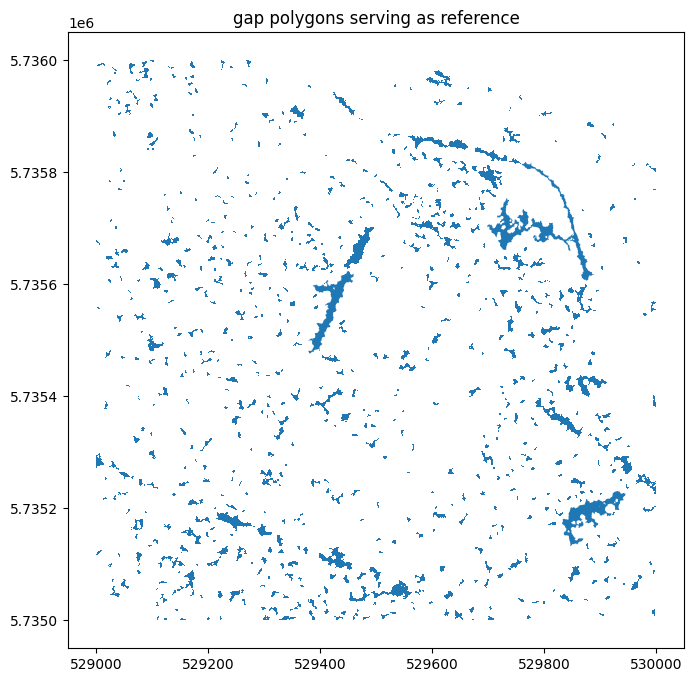

In [6]:
# read gap polygons
gap_polys_path = processed_data_dir / 'gap_polygons_ALS'

gap_polys_test = gpd.read_file(gap_polys_path / 'gap_polys_test_tile3.gpkg')

print(gap_polys_test)

# quick overview of the gap polygons
fig, ax = plt.subplots(figsize=(14,8))
gap_polys_test.plot(ax=ax)
ax.set_title('gap polygons serving as reference')
plt.show()

## 3. creation of one dataset
### 3.1 merge nDSMs and DOP into one dataset

In [7]:
# list to store merged datasets for nDSM lev0, lev1, and lev2
test_datasets = []

for ndsm_test in ndsm_datasets:
    
    # make copy of TDOP dataset
    dop_test_copy = dop_test_downsampled.copy()

    # add nDSM as new variable to TDOP (copy) dataset
    dop_test_copy['ndsm'] = (['y', 'x'], ndsm_test['band_1'].values)

    # copy the attributes
    dop_test_copy['ndsm'].attrs = ndsm_test['band_1'].attrs

    # convert spectral bands to float32 and ensure equal NoData values
    for band in dop_test_copy.data_vars:
        dop_test_copy[band] = dop_test_copy[band].astype('float32')
        dop_test_copy[band].rio.write_nodata(np.nan, inplace=True)
    
    # store the merged dataset in the list
    test_datasets.append(dop_test_copy)
    
print(test_datasets)

[<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 185.0 176.0 126.0 147.0 ... 90.0 114.0 126.0
    band_2       (y, x) float32 205.0 197.0 147.0 169.0 ... 100.0 125.0 133.0
    band_3       (y, x) float32 183.0 173.0 120.0 143.0 ... 89.0 103.0 106.0
    band_4       (y, x) float32 230.0 229.0 211.0 220.0 ... 157.0 175.0 172.0
    ndsm         (y, x) float32 23.89 24.59 24.59 23.99 ... 25.78 25.69 25.63
Attributes:
    AREA_OR_POINT:  Area, <xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 185.0 176.0 126.0 147.0 ... 9

### 3.2 add canopy gaps as raster mask to the dataset

In [8]:
# get geometries of the gap polygons
geom_test = [shapes for shapes in gap_polys_test.geometry]

# get parameters of the nDSM needed for the mask
# (same profile for all nDSM files)
with rasterio.open(processed_data_dir / 'nDSMs_DAP' / 'ndsm_test_tile3_lev0.tif') as src:
    profile_test = src.profile

# rasterize the polygons
# --> values 0 (non-gap) and 1 (gap)
test_mask = rasterize(
    geom_test,
    out_shape=(profile_test['height'], profile_test['width']),
    fill=0,
    transform=profile_test['transform'],
    all_touched=True,
    default_value=1
)

# set attributes for gap_mask
fill_value_attrs = {
    '_FillValue': np.nan,
    'long_name': 'gap_mask',
}

# loop through each dataset in test_datasets to add gap_mask
for test_ds in test_datasets:
    
    # add gap_mask to the dataset
    test_ds['gap_mask'] = (['y', 'x'], test_mask)
    
    # apply attributes to gap_mask in the dataset
    test_ds['gap_mask'].attrs.update(fill_value_attrs)
    
    # convert to float32
    test_ds['gap_mask'] = test_ds['gap_mask'].astype('float32')
    
    print(test_ds)

<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 185.0 176.0 126.0 147.0 ... 90.0 114.0 126.0
    band_2       (y, x) float32 205.0 197.0 147.0 169.0 ... 100.0 125.0 133.0
    band_3       (y, x) float32 183.0 173.0 120.0 143.0 ... 89.0 103.0 106.0
    band_4       (y, x) float32 230.0 229.0 211.0 220.0 ... 157.0 175.0 172.0
    ndsm         (y, x) float32 23.89 24.59 24.59 23.99 ... 25.78 25.69 25.63
    gap_mask     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0

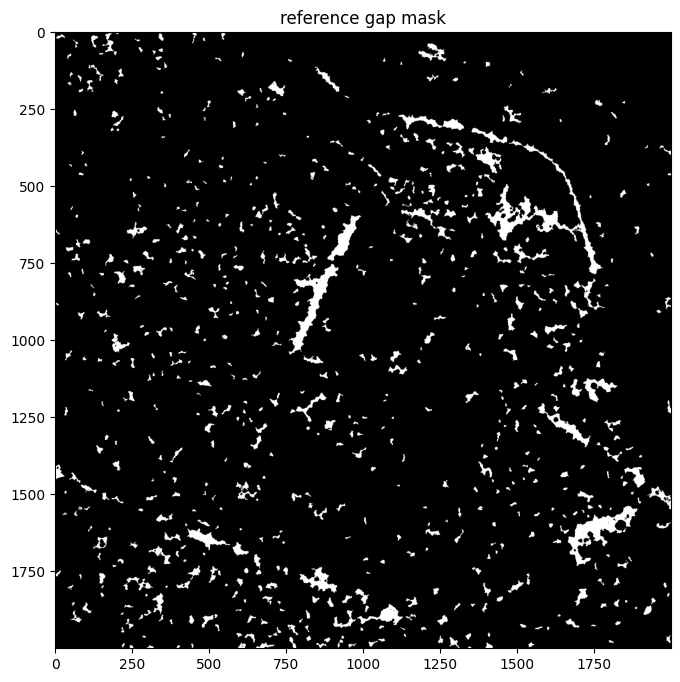

In [9]:
# plot the reference gap mask
fig, ax = plt.subplots(figsize=(14,8))
ax.imshow(test_datasets[0].gap_mask, cmap='gray')
ax.set_title('reference gap mask')
plt.show()

### 3.3 rename spectral bands in the dataset and save it to disk

In [10]:
# define the mapping for renaming spectral bands
new_variable_names = {'band_1': 'red', 'band_2': 'green', 'band_3': 'blue', 'band_4': 'nir'}

# dictionary mapping new variable names to their long names
long_names = {
    'red'  : 'red',
    'green': 'green',
    'blue' : 'blue',
    'nir'  : 'nir',
    'ndsm' : 'ndsm'
}

# function to update the long_name attribute
def update_long_names(dataset, long_name_mapping):
    for var_name, long_name in long_name_mapping.items():
        if var_name in dataset:
            dataset[var_name].attrs['long_name'] = long_name

# loop through each dataset in test_datasets and apply renaming and updating of long names
for i, test_ds in enumerate(test_datasets):
    
    # rename spectral bands for the current dataset
    test_ds = test_ds.rename(new_variable_names)
    
    # update long_name attributes in the current dataset
    update_long_names(test_ds, long_names)
    
    # replace the dataset in the list with the updated version
    test_datasets[i] = test_ds

    print(test_datasets[i])

<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 185.0 176.0 126.0 147.0 ... 90.0 114.0 126.0
    green        (y, x) float32 205.0 197.0 147.0 169.0 ... 100.0 125.0 133.0
    blue         (y, x) float32 183.0 173.0 120.0 143.0 ... 89.0 103.0 106.0
    nir          (y, x) float32 230.0 229.0 211.0 220.0 ... 157.0 175.0 172.0
    ndsm         (y, x) float32 23.89 24.59 24.59 23.99 ... 25.78 25.69 25.63
    gap_mask     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.29e+05 5.29e+05 5.29e+05 ... 5.3e+05 5.3e+05
  * y            (y) float64 5.736e+06 5.736e+06 ... 5.735e+06 5.735e+06
    spatial_ref  int32 0

In [11]:
# define path to final datasets
final_datasets_path = processed_data_dir / 'datasets'

# list filenames for saving the datasets (one for each level)
output_filenames_tif = ['test_ds_tile3_lev0.tif', 'test_ds_tile3_lev1.tif', 'test_ds_tile3_lev2.tif']
output_filenames_csv = ['test_ds_tile3_lev0.csv', 'test_ds_tile3_lev1.csv', 'test_ds_tile3_lev2.csv']

# iterate over each dataset and save them
for i, test_ds in enumerate(test_datasets):
    
    # define file paths for the tif and csv files
    tif_file = final_datasets_path / output_filenames_tif[i]
    csv_file = final_datasets_path / output_filenames_csv[i]
    
    # check if files already exist
    if not tif_file.exists() or not csv_file.exists():
        
        # save dataset 
        # as tif file
        test_ds.rio.to_raster(tif_file)
        
        # as csv file
        df_test = test_ds.to_dataframe()
        df_test.to_csv(csv_file)
        
        print(f'Test dataset level {i} saved.')
    
    else:
        
        # load existing datasets
        test_ds = rxr.open_rasterio(tif_file, band_as_variable=True)

        # use the long_names as variable names 
        for var_name in test_ds.data_vars:
            long_name = test_ds[var_name].attrs['long_name']
            test_ds = test_ds.rename({var_name: long_name})
        
        # replace the dataset in the list with the loaded version
        test_datasets[i] = test_ds

        print('Existing test dataset loaded.')

Test dataset level 0 saved.
Test dataset level 1 saved.
Test dataset level 2 saved.


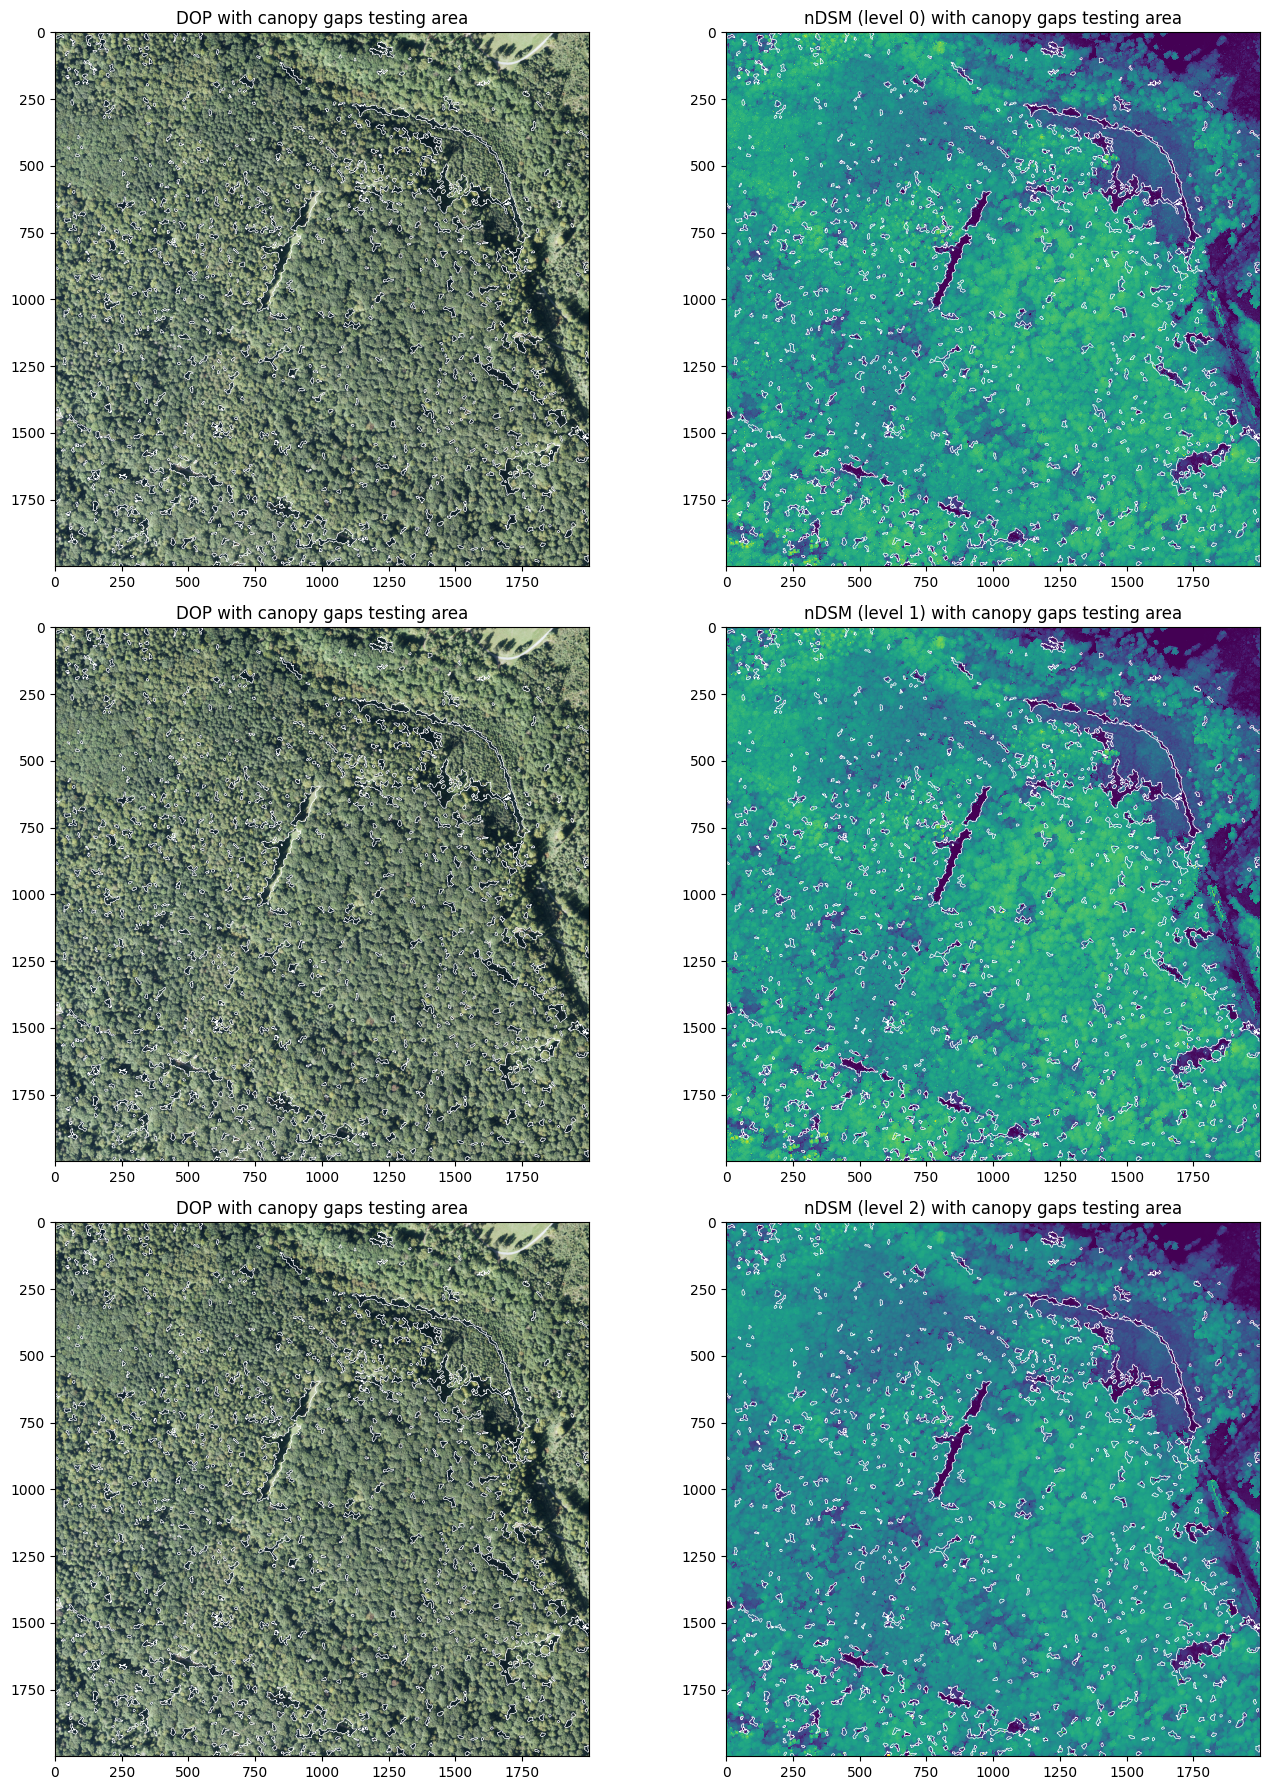

In [12]:
# final plot
#------------

fig, ax = plt.subplots(3, 2, figsize=(14, 18))

for i, test_ds in enumerate(test_datasets):
    
    # normalize RGB bands to [0, 1] range
    rgb_norm = np.stack([test_ds.red, test_ds.green, test_ds.blue]).transpose(1, 2, 0)
    rgb_norm = (rgb_norm - rgb_norm.min()) / (rgb_norm.max() - rgb_norm.min())
    
    # plot RGB-DOP
    ax[i, 0].imshow(rgb_norm)
    ax[i, 0].contour(test_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
    ax[i, 0].set_title('DOP with canopy gaps testing area')
    
    # plot nDSM in different levels
    ax[i, 1].imshow(test_ds.ndsm, cmap='viridis', interpolation='none')
    ax[i, 1].contour(test_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
    ax[i, 1].set_title(f'nDSM (level {i}) with canopy gaps testing area')

plt.tight_layout()
plt.show()